In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

In [ ]:
def compute_disparity(left, right, window_size, max_disparity=64, metric='SAD'):
    pad = window_size // 2
    padded_left = cv2.copyMakeBorder(left, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=0)
    padded_right = cv2.copyMakeBorder(right,pad, pad, pad + max_disparity, pad, cv2.BORDER_CONSTANT, value=0)
    
    height, width = left.shape
    disparity = np.zeros_like(left, dtype=np.uint8) #disparity initialziation
    
    for y in range(height):
        for x in range(width):
            d_max = min(max_disparity, x) #avoid out of bounds search range
            best_d, min_cost = 0, float('inf')

            # grab the left window
            wl = padded_left[y : y + window_size,
                             x : x + window_size]

            # search over disparities
            for d in range(d_max + 1):
                xr = x + max_disparity - d #The right image is padded with extra space (pad + max_disparity on the right)
                wr = padded_right[y : y + window_size,
                                  xr : xr + window_size]

                if metric == 'SAD':
                    cost = np.sum(np.abs(wl - wr))
                else:  # SSD
                    cost = np.sum((wl - wr)**2)

                if cost < min_cost:
                    min_cost, best_d = cost, d

            disparity[y, x] = best_d

    
    return disparity

#### **Explaination of critical ideas:**
1. **Padding (`pad`):**
   - **Purpose:** Add borders to handle edge pixels when extracting windows.  
   - **Calculation:** `pad = window_size // 2` ensures the window can extend beyond the original image edges.  
   - **Left Image Padding:** Symmetrically padded by `pad` on all sides.  
   - **Right Image Padding:** Asymmetrically padded with `pad + max_disparity` on the right side to accommodate searching for disparities up to `max_disparity`.

2. **Max Disparity (`max_disparity=64`):**
   - **Why 64?** A practical trade-off between computation time and depth resolution. Larger values detect closer objects but increase runtime.  
   - **Constraint:** `d_max = min(max_disparity, x)` ensures the search does not exceed the left boundary of the image.

3. **Window Matching (SAD vs. SSD):**
   - **SAD (Sum of Absolute Differences):** Computes `Σ|wl - wr|`. Robust to small intensity variations.  
   - **SSD (Sum of Squared Differences):** Computes `Σ(wl - wr)^2`. Punishes large differences more aggressively.  

4. **Output (`disparity` matrix):**
   - **Data Type:** `uint8` (values range from 0 to `max_disparity`).  
   - **Interpretation:** Each pixel stores the disparity (shift in pixels) required to align the left and right images. Higher values = closer objects.


Disparity matrix (window=1, metric=SAD):


0    1    2    3    4    5    6    7    8    9    ...  372  373  374  \
0      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
2      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
4      0    0    0    0    1    5    3    4    5    6  ...    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
284    0    1    2    3    1    5    3    4    0    0  ...    1    2    1   
285    0    1    2    3    4    5    1    2    8    9  ...    0    0    0   
286    0    0    2    3    0    5    0    7    8    0  ...    0    0    0   
287    0    1    2    0    0    5    1    0    8    1  ...    2    4    9   
288    0    0    0    0    0    0    0    0    0    0  ...    3    4    3   

     375  376  377  378  379  380  381  
0      0    0    0    0    0    0    0  
1      0    0    0    0    0    0    0  
2      0    0    0    0    0    0    0  
3      1    0    0    0    0    0    0  
4      1    0    0    0    0    0    0  
..   ...  ...  ...  ...  ...  ...  ...  
284    2    3    0    0    0    0   49  
285    1    2    3    4    5    6    0  
286    0    2    0    2    0    0    0  
287    1   11    0    8    1    2   26  
288    4    7    6    0    1    0    1  

[289 rows x 382 columns]


Disparity matrix (window=1, metric=SSD):


0    1    2    3    4    5    6    7    8    9    ...  372  373  374  \
0      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
2      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
4      0    1    2    3    0    5    3    4    5    5  ...    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
284    0    1    2    3    0    5    0    0    0    0  ...    1    2    1   
285    0    1    2    3    4    5    0    0    8    9  ...    0    0    0   
286    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
287    0    1    2    0    0    5    0    0    8    1  ...    2    4    1   
288    0    0    0    0    0    0    0    0    0    0  ...    3    0    3   

     375  376  377  378  379  380  381  
0      0    0    0    0    0    0    0  
1      0    0    0    0    0    0    0  
2      0    0    0    0    0    0    0  
3      1    0    0    0    0    0    0  
4      1    0    0    0    0    0    0  
..   ...  ...  ...  ...  ...  ...  ...  
284    2    3    0    0    0    0    0  
285    1    2    3    4    5    6   25  
286    0    2   46    2    0    0    0  
287    1    0    0    8    1    2   26  
288    4    1    6    0    1    0    2  

[289 rows x 382 columns]

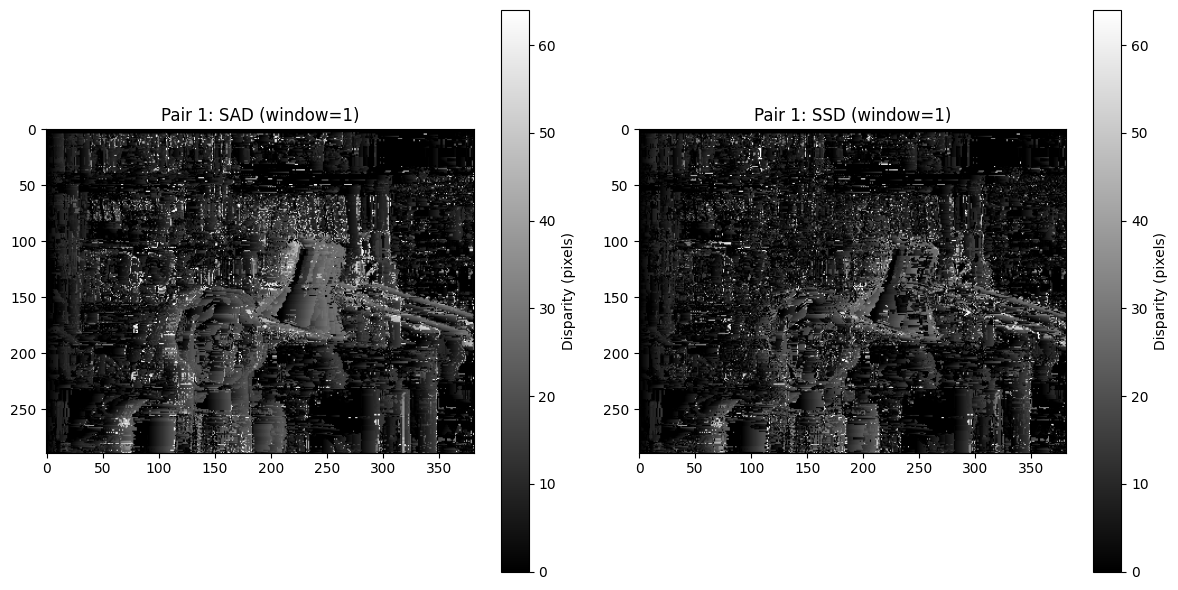


Disparity matrix (window=5, metric=SAD):


0    1    2    3    4    5    6    7    8    9    ...  372  373  374  \
0      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
2      0    0    2    0    0    0    0    0    1    5  ...    0    0    0   
3      0    1    2    3    0    5    6    6    6    7  ...    0    1    3   
4      0    1    2    3    4    5    6    6    6    7  ...    0    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
284    0    1    2    3    4    4    6    7    8    9  ...   19   19   21   
285    0    1    2    3    3    5    6    7    8    9  ...   18   19   20   
286    0    1    2    3    4    5    5    7    8    9  ...   16   19    2   
287    0    1    2    3    4    5    5    7    8    9  ...   15    0    0   
288    0    1    2    3    3    5    5    7    8    9  ...   45    0    0   

     375  376  377  378  379  380  381  
0      0    0    0    0    0    0    0  
1      0    0   11    0    0    0    0  
2      0    0    0    0    0    0    0  
3      3    1    7    7    0    0    0  
4      3    6    7    7    0    0    0  
..   ...  ...  ...  ...  ...  ...  ...  
284   21   23   23   25    0    0    0  
285   21   22   33    0    0    0    0  
286   21   22   23    0    0    0    0  
287    0    0    0    0    0    0    0  
288    0    0    0    0    0    0    0  

[289 rows x 382 columns]


Disparity matrix (window=5, metric=SSD):


0    1    2    3    4    5    6    7    8    9    ...  372  373  374  \
0      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1      0    0    0    0    0    0    0    0    0    0  ...    0   30   30   
2      0    0    0    0    0    0    4    5    6    7  ...    0    1    2   
3      0    0    0    0    0    3    4    5    6    7  ...    0    1    3   
4      0    0    0    1    0    3    4    5    6    7  ...    0    1    8   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
284    0    0    0    2    2    0    2    5    0    5  ...    3    6    6   
285    0    0    0    2    2    0    0    5    0    5  ...    6    6    5   
286    0    0    0    0    2    0    3    5    3    6  ...    6    6    3   
287    0    0    0    0    0    0    3    0    3    6  ...    6    6    5   
288    0    0    0    0    0    0    3    3    3    3  ...    6    6   15   

     375  376  377  378  379  380  381  
0      0    0    0    0    0    0    0  
1     30   51   11    0    0    0    0  
2      5    6    6    0    0    0    0  
3      3    6    7    7    0    0    0  
4     11    7   11   11    0    0    0  
..   ...  ...  ...  ...  ...  ...  ...  
284    3    2    2    8    0    0    0  
285    7    7    7    7    7    0    0  
286    5    5    7    7    7    0    0  
287    5    5    7    7    7    0    0  
288   15   12    1   20    0    0    0  

[289 rows x 382 columns]

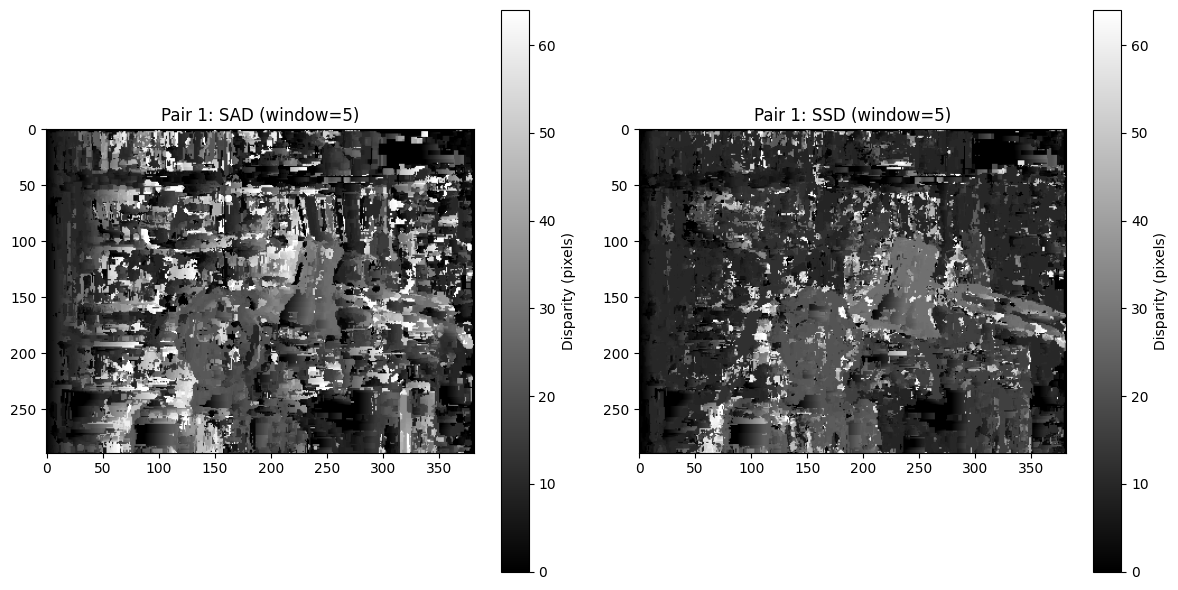


Disparity matrix (window=9, metric=SAD):


0    1    2    3    4    5    6    7    8    9    ...  372  373  374  \
0      0    0    0    0    0    5    5    7    0    0  ...    0    0    0   
1      0    0    0    0    0    5    6    7    0    0  ...    0    0    0   
2      0    0    0    3    4    5    6    7    7    0  ...    0    0    0   
3      0    0    0    3    4    5    6    7    7    7  ...    0    0    0   
4      0    0    2    3    4    5    6    7    7    7  ...    0    0    3   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
284    0    1    2    3    4    5    6    7    8    9  ...   20    0    0   
285    0    1    2    3    4    5    6    7    8    9  ...   24   24    0   
286    0    1    2    3    4    5    6    7    8    9  ...   21   21   23   
287    0    1    2    3    4    5    6    7    8    9  ...   25   22   22   
288    0    1    1    3    4    5    6    7    8    9  ...   20   21   22   

     375  376  377  378  379  380  381  
0      0    0    0    0    0    0    0  
1      0    0    0    0    0    0    0  
2      0    0    0    0    0    0    0  
3      0    0    0    0    0    0    0  
4      0    3    0    0    0    0    0  
..   ...  ...  ...  ...  ...  ...  ...  
284    0    0    0    0    0    0    0  
285    0    0    0    0    0    0    0  
286    0    0    0    0    0    0    0  
287   25    0    0    0    0    0    0  
288   23    0    0    0    0    0    0  

[289 rows x 382 columns]


Disparity matrix (window=9, metric=SSD):


0    1    2    3    4    5    6    7    8    9    ...  372  373  374  \
0      0    0    0    0    0    0    0    0    5    5  ...    0    0    0   
1      0    0    0    0    0    0    0    4    4    5  ...    0    0    1   
2      0    0    0    0    0    0    0    3    4    5  ...    0    1    7   
3      0    0    0    0    0    0    0    3    5    5  ...    5    5    7   
4      0    0    0    0    0    0    0    3    4    5  ...    5    5    7   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
284    0    0    0    0    0    0    0    0    2    5  ...    3    5    5   
285    0    0    0    0    0    0    0    0    2    5  ...    5    5    5   
286    0    0    0    0    0    0    0    0    2    5  ...    3    5    5   
287    0    0    0    0    0    0    0    3    3    5  ...    5    5    5   
288    0    0    0    0    0    0    0    3    3    5  ...    3    5    5   

     375  376  377  378  379  380  381  
0      0    0    0    0    0    0    0  
1      1    1    0    0    0    0    0  
2      7    8    0    0    0    0    0  
3      7    7    0    0    0    0    0  
4      7    7    0    0    0    0    0  
..   ...  ...  ...  ...  ...  ...  ...  
284    6    7    0    0    0    0    0  
285    6    7    7    0    0    0    0  
286    6    7    7    0    0    0    0  
287    6    7    7    0    0    0    0  
288    6    7    7    0    0    0    0  

[289 rows x 382 columns]

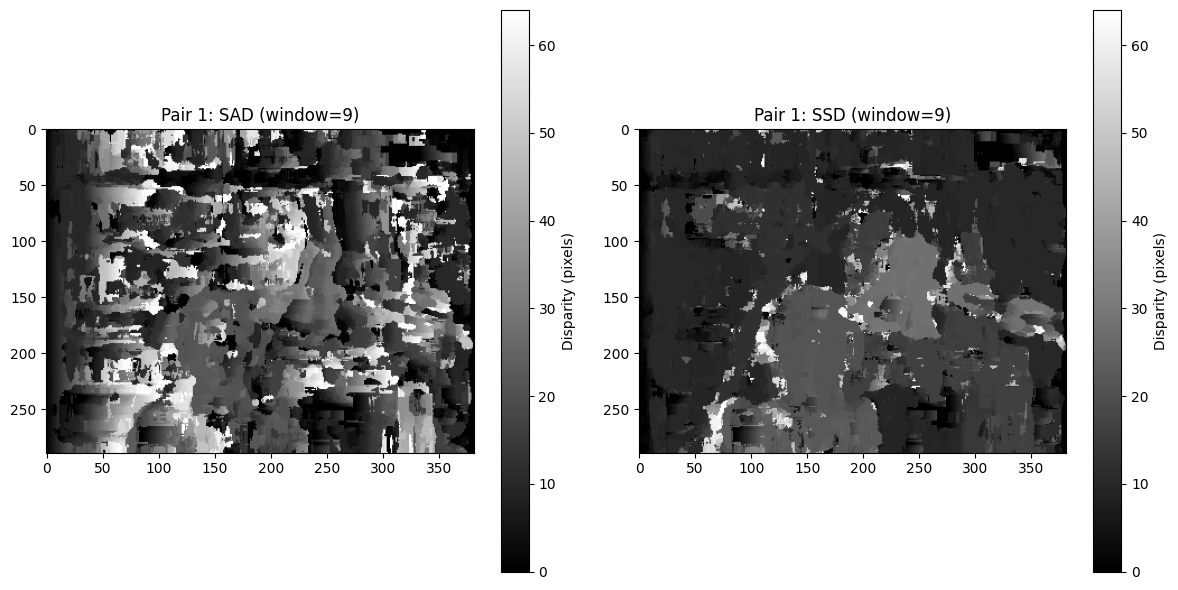


Disparity matrix (window=1, metric=SAD):


0    1    2    3    4    5    6    7    8    9    ...  440  441  442  \
0      0    1    2    0    0    0    3    5    0    0  ...   63   46    1   
1      0    0    0    1    0    0    1    7    8    0  ...   48    0   48   
2      0    0    1    2    3    0    1    2    3    0  ...   49   49   49   
3      0    1    2    3    0    1    2    3    6    7  ...   40    0   58   
4      0    1    1    0    0    1    6    7    8    0  ...   59   41   51   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
370    0    0    1    2    3    4    0    0    1    2  ...   45   42   44   
371    0    1    2    0    1    2    3    4    5    6  ...   35   48   45   
372    0    1    2    3    4    5    6    7    8    9  ...   47   52   36   
373    0    1    2    0    0    1    2    3    4    5  ...   25   22   40   
374    0    0    0    1    2    3    4    5    6    7  ...   25   24   36   

     443  444  445  446  447  448  449  
0     44   22   50   52   53   10   14  
1      1    3    4   52   10   13   10  
2     42    2    4   14   15   25   13  
3      1    2   57   29   10   11   32  
4     52    0    1    1   31   12   33  
..   ...  ...  ...  ...  ...  ...  ...  
370   44   45   42   42   47   48   49  
371   46   54   40   53   42   46   51  
372   33   63   35   36   50   49   34  
373   27   29   26   44   48   50   26  
374   53   39   40   24   23   16   19  

[375 rows x 450 columns]


Disparity matrix (window=1, metric=SSD):


0    1    2    3    4    5    6    7    8    9    ...  440  441  442  \
0      0    0    1    2    1    4    3    6    6    7  ...    0   46    1   
1      0    0    1    2    3    1    6    1    2    0  ...   48    0   35   
2      0    0    1    3    4    2    5    0    2    2  ...   11   43   14   
3      0    0    2    2    2    2    2    0    6    0  ...   12   16   13   
4      0    1    1    0    3    2    6    3    6    2  ...   13   12   51   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
370    0    1    1    0    1    0    0    2    1    1  ...    4   42    3   
371    0    0    0    0    1    2    4    4    3    5  ...   33   12    1   
372    0    1    0    3    2    4    2    3    6    8  ...   47   22    3   
373    0    0    0    1    4    2    4    3    1    6  ...   10   36   40   
374    0    0    1    0    1    5    1    1    2    4  ...    4   24   25   

     443  444  445  446  447  448  449  
0     19   22   50   14    3    2   14  
1      1    3    4   39    2    2   54  
2     36    2    0    4    5    4   13  
3     10   11   57    2    4    5    5  
4     52    0    1   13   31    1   33  
..   ...  ...  ...  ...  ...  ...  ...  
370    9   12   15    3   37   48   26  
371   11    6   38   18    4   16    1  
372   19    7   21    0   10   10    6  
373    1    4   40   44   42   18    2  
374   12    8   21    2   23   16    0  

[375 rows x 450 columns]

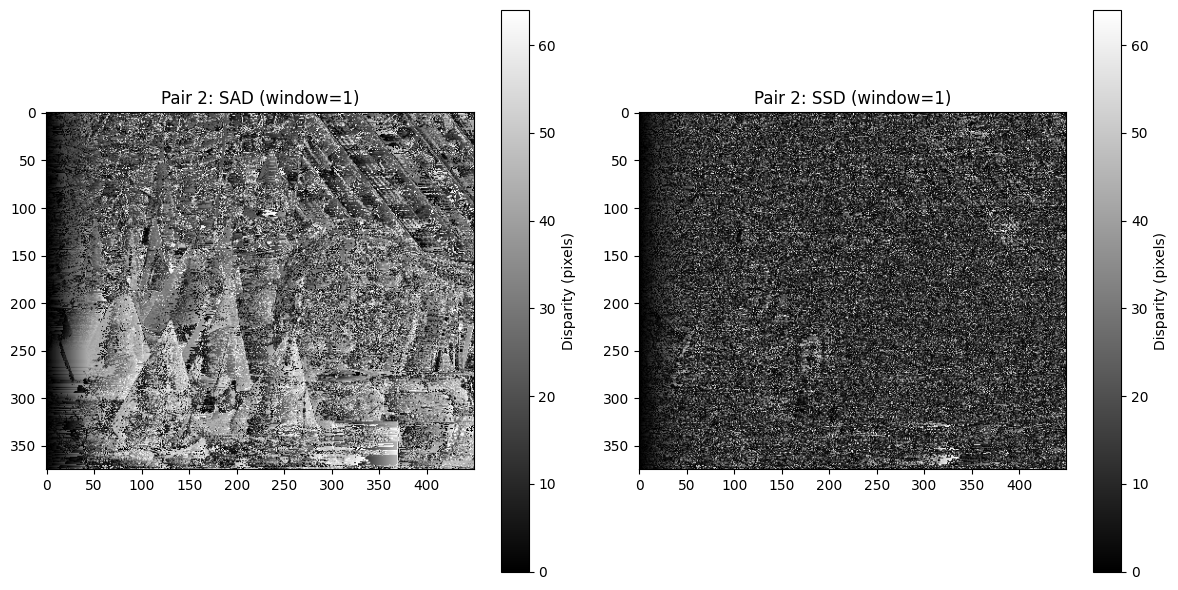


Disparity matrix (window=5, metric=SAD):


0    1    2    3    4    5    6    7    8    9    ...  440  441  442  \
0      0    1    2    3    4    5    6    7    8    9  ...   57   46   59   
1      0    1    2    3    4    5    6    7    8    9  ...   55   46   47   
2      0    1    1    3    4    5    6    7    8    9  ...   55   47   48   
3      0    1    0    3    4    5    6    7    8    9  ...   64   64   48   
4      0    0    0    1    4    5    6    7    8    9  ...   64   64   64   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
370    0    1    2    3    4    5    6    7    8    9  ...   49   51   51   
371    0    1    2    3    4    5    6    7    8    9  ...   49   51   51   
372    0    1    2    3    4    5    6    7    8    9  ...   49   49   52   
373    0    1    2    3    4    5    6    7    8    9  ...   49   49   53   
374    0    1    2    3    4    5    6    7    8    9  ...   49   36   36   

     443  444  445  446  447  448  449  
0     59   59   59   59   64   59    0  
1      0    0    1   59   59   59    0  
2      0    0    0    1   59   59    0  
3      0    0    0    1    1    0    0  
4      0    0    0    1    1    0    0  
..   ...  ...  ...  ...  ...  ...  ...  
370   52   57   54   54   56   50   50  
371   52   53   54   54   56   50   50  
372   52   53   53   54   56   49   50  
373   52   53   53   54   56   49   50  
374   52   53   53   42   42   49   50  

[375 rows x 450 columns]


Disparity matrix (window=5, metric=SSD):


0    1    2    3    4    5    6    7    8    9    ...  440  441  442  \
0      0    1    1    1    1    5    5    5    2    2  ...   49   48   51   
1      0    0    2    2    2    5    5    5    0    6  ...   49   50   58   
2      0    0    2    2    2    5    6    6    6    2  ...   58   58   58   
3      0    0    0    0    4    5    2    6    6    2  ...   57   58   59   
4      0    0    0    0    4    2    2    2    2    2  ...   55   57   58   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
370    0    1    1    1    1    1    1    1    3    3  ...   45   44   44   
371    0    1    1    1    1    1    1    1    5    5  ...   45   45   44   
372    0    1    1    1    4    5    1    3    3    3  ...   45   42   45   
373    0    1    1    1    4    5    6    5    5    3  ...   48   22   58   
374    0    1    1    1    4    5    6    5    5    3  ...   48   48   48   

     443  444  445  446  447  448  449  
0     53   61   61   25    9   18   39  
1     59   60   57   57    9   41    9  
2     59   60   58   58   18   18    9  
3     58   61   62   58   39   41   38  
4     58    2    2   62   42   38   39  
..   ...  ...  ...  ...  ...  ...  ...  
370   44   44   44   44   45   44   44  
371   44   44   44   44   45   44   44  
372   53   53   58   58   48   43    0  
373   58   53   58   52   52   26    0  
374   53   52   48   52   52    0    0  

[375 rows x 450 columns]

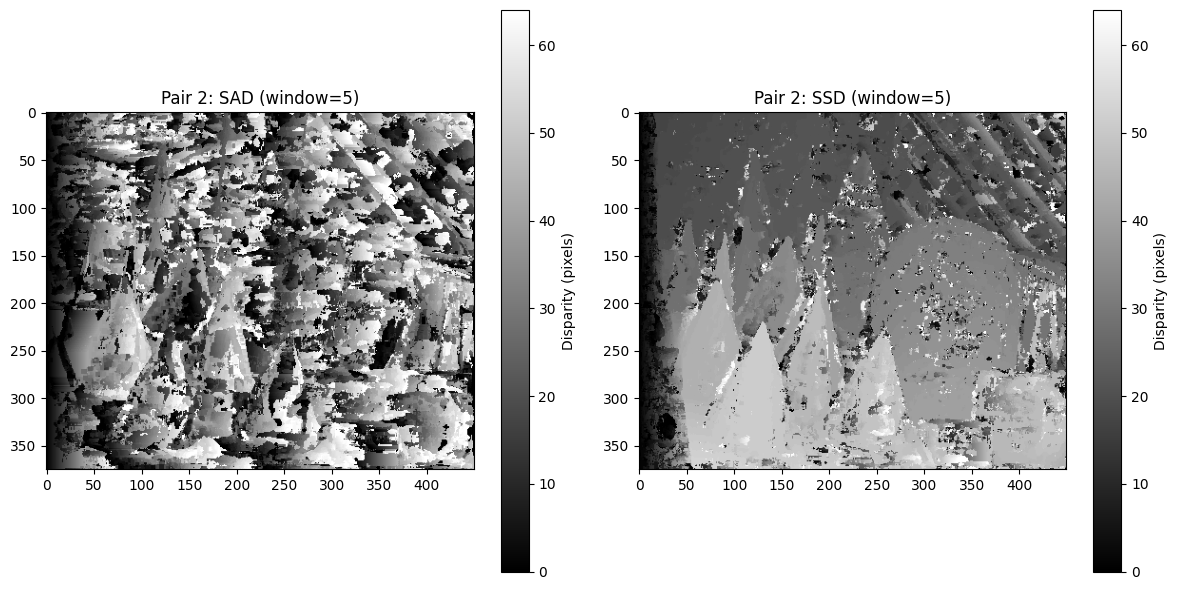


Disparity matrix (window=9, metric=SAD):


0    1    2    3    4    5    6    7    8    9    ...  440  441  442  \
0      0    1    1    3    4    5    6    7    8    9  ...   64   55   64   
1      0    1    1    3    4    5    6    7    8    9  ...   64   64   64   
2      0    1    1    3    4    5    6    7    8    0  ...   64   64   64   
3      0    1    1    3    4    5    6    7    8    0  ...   64   64   64   
4      0    1    1    3    4    5    6    7    0    0  ...   64   64   64   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
370    0    1    2    3    4    5    6    7    8    9  ...   63   64   49   
371    0    1    2    3    4    5    6    7    8    9  ...   63   64   49   
372    0    1    2    3    4    5    6    7    8    9  ...   63   64   49   
373    0    1    2    3    4    5    6    7    8    9  ...   63   64   49   
374    0    1    2    3    4    5    6    7    8    9  ...   62   49   49   

     443  444  445  446  447  448  449  
0     59   49   59    0    0    0    0  
1     64   64    0    0    0    0    0  
2     64   64    0    0    0    0    0  
3     64   64    0    0    0    0    0  
4     64   64   64    0    0    0    0  
..   ...  ...  ...  ...  ...  ...  ...  
370   49   50   53   49   49   49   49  
371   49   50   53   53   49   49   49  
372   49   50   53   53   50   50   49  
373   49   53   53   53   53   50   49  
374   49   53   53   53   53   56   56  

[375 rows x 450 columns]


Disparity matrix (window=9, metric=SSD):


0    1    2    3    4    5    6    7    8    9    ...  440  441  442  \
0      0    1    2    2    2    2    2    2    2    2  ...   55   55   57   
1      0    1    2    2    2    5    2    2    2    2  ...   55   56   57   
2      0    1    2    2    2    2    2    2    2    2  ...   55   56   57   
3      0    1    2    2    2    2    6    6    2    2  ...   55   56   57   
4      0    1    2    2    2    2    6    6    2    2  ...    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
370    0    1    1    1    1    1    1    1    1    5  ...   45   45   45   
371    0    1    1    1    1    1    1    1    1    1  ...   45   45   45   
372    0    1    1    1    1    1    1    1    1    1  ...   45   45   45   
373    0    1    1    1    1    1    1    1    1    1  ...   45   45   45   
374    0    1    1    1    4    5    5    5    1    3  ...   45   45   42   

     443  444  445  446  447  448  449  
0     58   58   58   58   58   58   57  
1     58   58   58   58   58   58    0  
2     58   58   61   58   58   58    0  
3     58   58   58   58   58    0    0  
4      2    2    2   58    0    0    0  
..   ...  ...  ...  ...  ...  ...  ...  
370   45   44   45   44   44   44   45  
371   45   44   45   44   44   44    0  
372   45   44   45   44   44   44    0  
373   45   45   45   44   45    0    0  
374   42   42   45   53   51    0    0  

[375 rows x 450 columns]

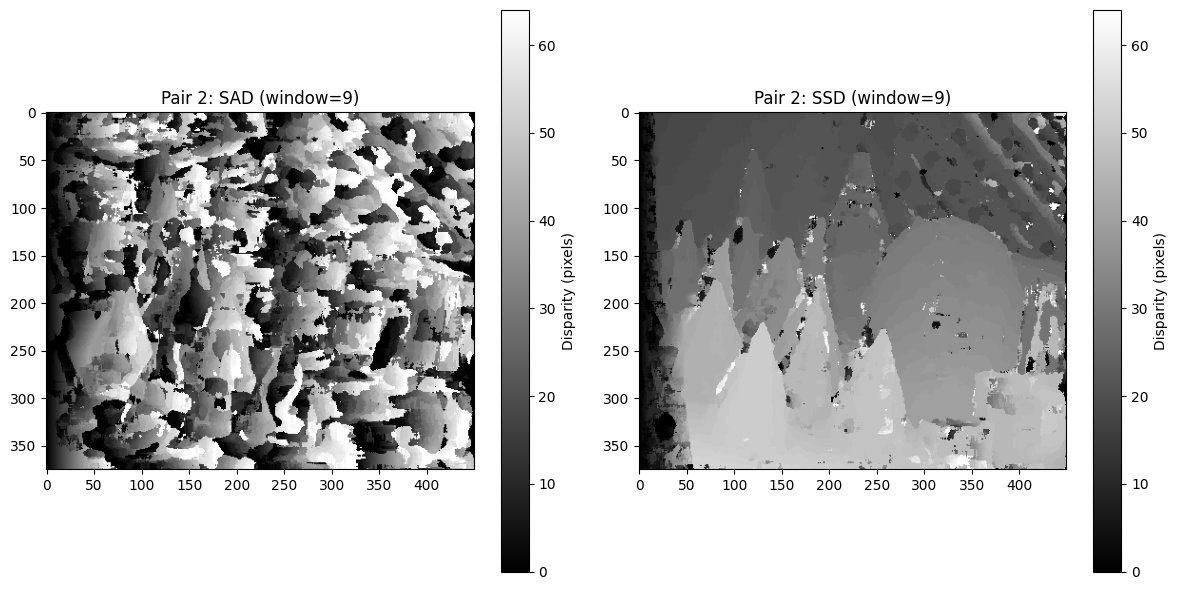


Disparity matrix (window=1, metric=SAD):


0    1    2    3    4    5    6    7    8    9    ...  440  441  442  \
0      0    0    1    0    0    0    1    2    3    4  ...   34   25   36   
1      0    1    2    3    0    1    2    3    4    5  ...    0   12   13   
2      0    0    1    2    0    1    2    3    4    5  ...   32   33   20   
3      0    0    0    0    1    2    3    4    5    6  ...    1   14   26   
4      0    1    2    0    1    2    3    4    5    1  ...   17   20    2   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
370    0    1    2    3    0    2    0    6    4    8  ...   55   27    5   
371    0    1    0    0    0    0    4    4    0    4  ...   11    3    9   
372    0    0    0    0    1    0    4    5    5    0  ...   10   21   14   
373    0    1    0    3    1    1    5    5    2    8  ...    7    6    7   
374    0    1    0    1    0    1    4    5    1    1  ...   46   36   47   

     443  444  445  446  447  448  449  
0     26    4   39   40   41   42   43  
1      3   29    6   32   33    7    0  
2     35   24   11   11    0    0    4  
3     27   61   11    5    0   16    6  
4     42   35   16   17    6   17    8  
..   ...  ...  ...  ...  ...  ...  ...  
370   41   14    7   50   45    5    0  
371   10   18   44    5    1    2   19  
372   63   24   23   59   52   17   62  
373    5   11   10   15   15   15   17  
374   22   49   51   51   17   61    2  

[375 rows x 450 columns]


Disparity matrix (window=1, metric=SSD):


0    1    2    3    4    5    6    7    8    9    ...  440  441  442  \
0      0    1    2    0    1    0    3    5    3    3  ...   17   25   19   
1      0    1    0    0    4    0    6    1    6    2  ...   18   12   13   
2      0    1    2    1    4    5    2    0    3    5  ...    5    6   10   
3      0    0    2    3    0    1    0    3    1    3  ...    1   14    1   
4      0    1    0    0    0    2    0    3    7    1  ...   11   20    2   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
370    0    1    0    3    0    4    0    6    4    3  ...    4   15    5   
371    0    0    1    0    0    1    1    4    7    8  ...   11    3    9   
372    0    1    0    0    1    0    4    5    5    0  ...   10   21    3   
373    0    1    1    1    1    1    3    1    2    8  ...    7    6    7   
374    0    1    0    3    0    1    6    5    1    1  ...    4   20   15   

     443  444  445  446  447  448  449  
0     26    4   25   26   27   25   26  
1     21   29    6   32   33    7    0  
2      8   24   35   22   17   18    4  
3      1   61   11    4    6    6    0  
4     50   35   16   17    6   17    8  
..   ...  ...  ...  ...  ...  ...  ...  
370   41    2    1    0   45    5    0  
371   10   16   12   38    1    2   12  
372    9   24    0   26   52   17    6  
373    5   11   10   13   15   15   17  
374    6   21    8   40    3    4    2  

[375 rows x 450 columns]

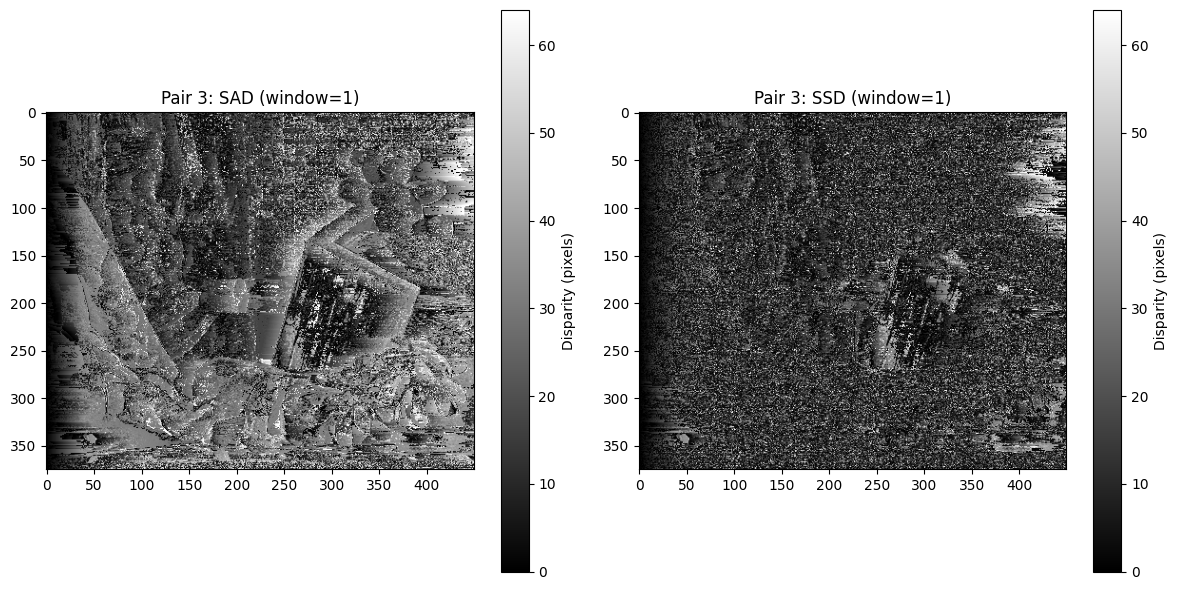


Disparity matrix (window=5, metric=SAD):


0    1    2    3    4    5    6    7    8    9    ...  440  441  442  \
0      0    1    2    3    4    5    6    7    8    9  ...   52   43   43   
1      0    1    2    3    4    5    6    7    8    9  ...   52   43   21   
2      0    1    2    3    4    5    6    7    8    9  ...   20   43   43   
3      0    1    2    3    4    5    6    7    8    9  ...   20   21   55   
4      0    1    2    3    4    5    6    7    8    9  ...    6   27   61   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
370    0    0    0    0    0    0    0    0    4    4  ...   13   15   32   
371    0    0    0    0    0    0    0    0    4    4  ...   32   19   32   
372    0    0    0    0    0    0    0    0    5    5  ...   19   19   19   
373    0    0    0    0    0    0    0    1    5    5  ...   19   19   23   
374    0    0    0    0    0    0    0    5    5    5  ...   19   19   23   

     443  444  445  446  447  448  449  
0     44   45   58   29   60   32   32  
1     44   45   58   29   60   60   32  
2     44   45   58   29   60   33   32  
3     44   61   58   40   42   49   44  
4     49   61   62   63   55   55   33  
..   ...  ...  ...  ...  ...  ...  ...  
370   15   15   30   19   57    0    0  
371   23   23   19   19   23    0    0  
372   23   23   23   23   23   19   19  
373   23   23   23   23   23   34   34  
374   23   23   23   23   27   27   30  

[375 rows x 450 columns]


Disparity matrix (window=5, metric=SSD):


0    1    2    3    4    5    6    7    8    9    ...  440  441  442  \
0      0    1    2    3    4    4    5    5    2    2  ...   13    3    4   
1      0    1    2    3    4    5    5    5    5    5  ...   13    3    4   
2      0    1    2    3    0    0    5    5    5    1  ...    2    3    4   
3      0    0    2    3    3    5    5    5    2    1  ...   25    3    4   
4      0    0    2    3    3    5    5    5    5    5  ...   15    3    4   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
370    0    0    0    0    0    0    0    4    4    4  ...   59   50   49   
371    0    0    0    1    0    1    1    1    8    8  ...   44   52   49   
372    0    1    1    1    1    1    1    1    8    8  ...   52   52   52   
373    0    1    1    1    1    1    1    1    8    8  ...   49   49   49   
374    0    1    1    1    1    1    1    1    1    1  ...    6    2    6   

     443  444  445  446  447  448  449  
0      4   15   15   15    4   17    0  
1     15   15   15   15   15    4    0  
2      4   15   15   15   15    0    0  
3      4    4   15   15    4    0    0  
4      4    4   15   15    4    4    0  
..   ...  ...  ...  ...  ...  ...  ...  
370    7   50   61    3    7   53    0  
371    7   48    7    7   48    7    0  
372   52   49    7   48   48   45    0  
373   49   49   49   49   48   49    0  
374    7   49   49   49   49   49    0  

[375 rows x 450 columns]

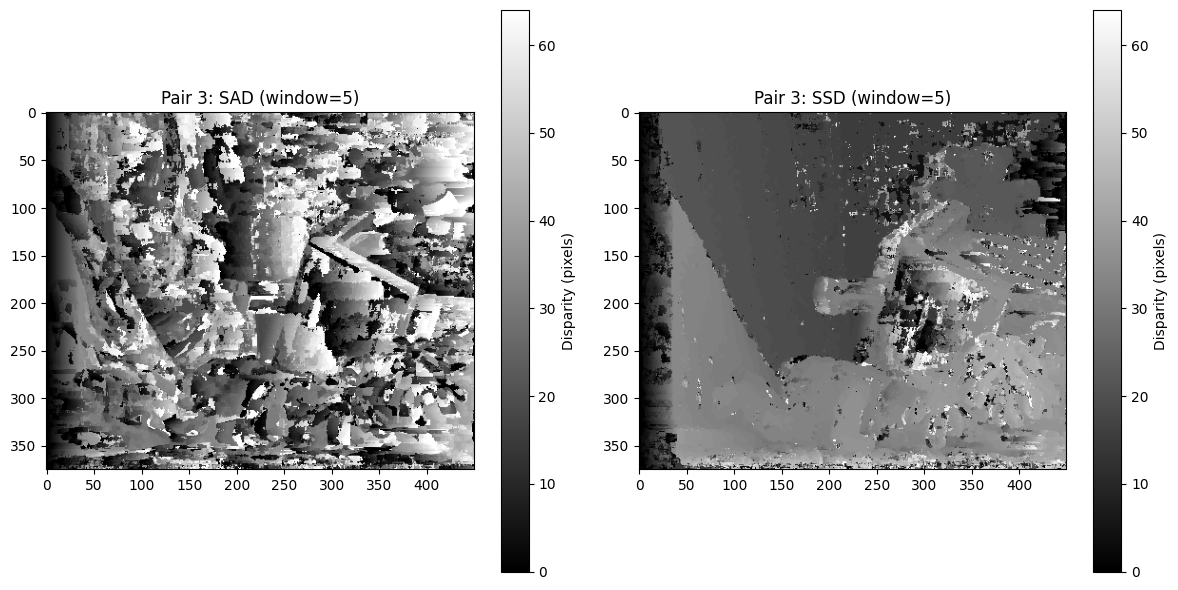


Disparity matrix (window=9, metric=SAD):


0    1    2    3    4    5    6    7    8    9    ...  440  441  442  \
0      0    1    2    3    4    5    6    7    8    9  ...   56   56   56   
1      0    1    2    3    4    5    6    7    8    9  ...   44   56   56   
2      0    1    2    3    4    5    6    7    8    9  ...   22   22   57   
3      0    1    2    3    4    5    6    7    8    9  ...   22   22   57   
4      0    1    2    3    4    5    6    7    8    9  ...   22   22   57   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
370    0    0    0    0    0    0    0    0    0    0  ...   36   36   51   
371    0    0    0    0    0    0    0    0    0    0  ...   23   23   19   
372    0    0    0    0    0    0    0    0    0    0  ...   23   23   19   
373    0    0    0    0    0    0    0    0    4    4  ...   19   19   19   
374    0    0    0    0    0    0    0    0    4    4  ...   19   19   19   

     443  444  445  446  447  448  449  
0     58   48   49   56   56   40   60  
1     58   55   49   61   46   40   60  
2     58   55   49   61   50   40   60  
3     58   55   49   61   62   40   42  
4     58   55   49   61   55   40   42  
..   ...  ...  ...  ...  ...  ...  ...  
370   19   19   23   19   19   19    0  
371   19   19   23   19   19   19    0  
372   19   19   23   19   19   19    0  
373   19   19   23   23   19   19    0  
374   19   19   23   23   23   23   23  

[375 rows x 450 columns]


Disparity matrix (window=9, metric=SSD):


0    1    2    3    4    5    6    7    8    9    ...  440  441  442  \
0      0    0    2    3    3    5    5    5    2    2  ...   15   15   15   
1      0    0    2    3    3    5    5    5    2    2  ...   15   15   15   
2      0    0    2    3    3    5    5    5    5    2  ...   15   15   15   
3      0    0    2    3    3    5    5    5    2    2  ...   15   15   15   
4      0    0    2    3    4    5    5    5    1    1  ...   15   15   15   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
370    0    0    1    1    1    1    1    1    1    1  ...   49   52   49   
371    0    0    0    0    1    1    1    4    1    1  ...   49   49   49   
372    0    0    0    0    1    1    1    1    1    1  ...   52   52   49   
373    0    0    0    1    1    1    1    1    1    1  ...   52   52   49   
374    0    1    1    1    1    1    1    1    1    1  ...   52   52   52   

     443  444  445  446  447  448  449  
0     15    4    4    4   15    0    0  
1     15    4    4    4   15    0    0  
2     15    4    4    4    4    0    0  
3     15    4    4    4    0    0    0  
4     15    4    4    4    0    0    0  
..   ...  ...  ...  ...  ...  ...  ...  
370   49   49   53   53   53    0    0  
371   49   49   49   49   49    0    0  
372   49   49   49   49   49    0    0  
373   52   49   49   49    0    0    0  
374   52   52    7   49   49    0    0  

[375 rows x 450 columns]

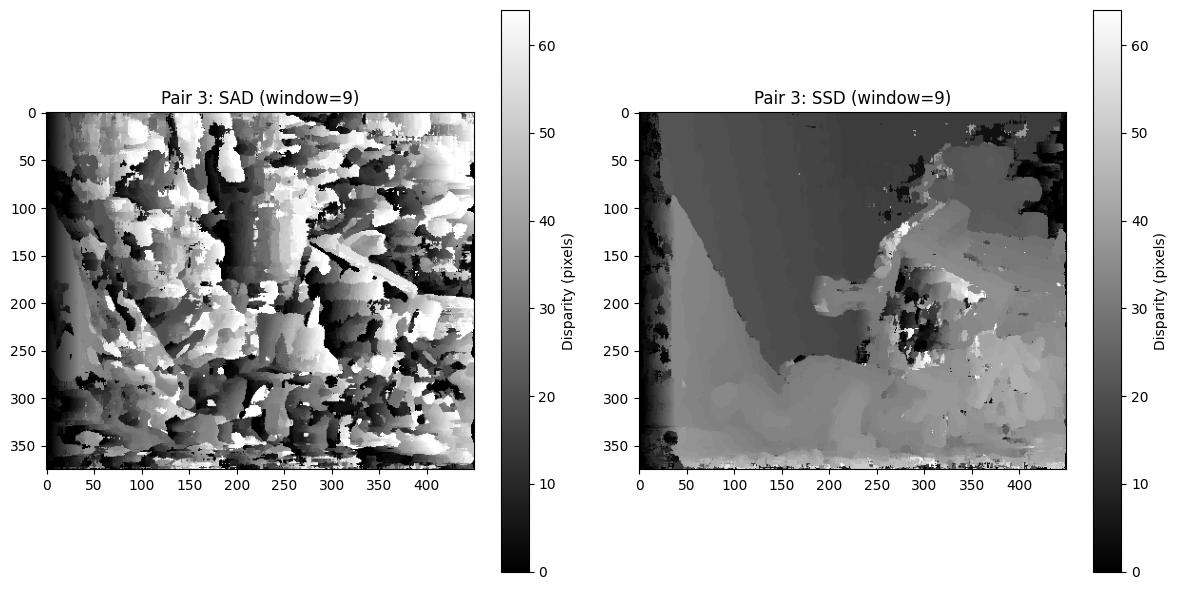

In [14]:
window_sizes = [1, 5, 9]
metrics = ['SAD', 'SSD']

pairs = [
    ('l1.png', 'r1.png'),
    ('l2.png', 'r2.png'),
    ('l3.png', 'r3.png'),
]

for idx, (l_path, r_path) in enumerate(pairs, start=1):
    left  = cv2.imread(l_path, cv2.IMREAD_GRAYSCALE)
    right = cv2.imread(r_path, cv2.IMREAD_GRAYSCALE)
    assert left is not None and right is not None, f"Couldn’t load {l_path} / {r_path}"

    for w in window_sizes:
        plt.figure(figsize=(12, 6))
        for i, metric in enumerate(metrics):
            disp = compute_disparity(left, right, w, metric=metric)
            print(f"\nDisparity matrix (window={w}, metric={metric}):")
            display(pd.DataFrame(disp))
            plt.subplot(1, 2, i+1)
            plt.imshow(disp, cmap='gray')
            plt.colorbar(label='Disparity (pixels)')
            plt.title(f'Pair {idx}: {metric} (window={w})')
        plt.tight_layout()
        plt.show()

#### **Key Concepts:**
1. **Disparity Matrix:**
   - **What It Represents:** A 2D array where each value indicates how many pixels a point in the left image must shift horizontally to match the right image.  
   - **Depth Correlation:** Higher disparity values (brighter pixels) = closer objects (less depth), lower values (darker pixels) = farther objects (D=bF/Z).

2. **Window Size Impact:**
   - **Small Windows (e.g., 1x1):**  
     - Pros: High detail preservation.  
     - Cons: Noisy (no spatial smoothing).  
   - **Large Windows (e.g., 9x9):**  
     - Pros: Smoother results (reduces noise).  
     - Cons: Blurs edges, misses fine structures.

3. **SAD vs. SSD Differences:**
   - **SAD:** Better for low-texture regions (e.g., walls).  
   - **SSD:** Better for high-contrast edges (e.g., objects with sharp boundaries).

4. **Visualization:**
   - **Grayscale Disparity Maps:** Use `cmap='gray'` to map disparity values to brightness.  
   - **Color Bar:** Shows the disparity scale (0 to `max_disparity`).